# Pytorch - MNIST

## import library

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

%matplotlib inline

## cuda 설정

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print('Current cuda device is', device)

Current cuda device is cuda


## 1) 데이터셋

In [5]:
train_data = datasets.MNIST(root = './',
                            train = True,
                            transform = transforms.ToTensor())
test_data = datasets.MNIST(root = './',
                           train = False,
                           transform = transforms.ToTensor())

print('number of training data : ', len(train_data))
print('number of test data : ', len(test_data))

number of training data :  60000
number of test data :  10000


In [16]:
image, label = train_data[0]

print('image shape : ', image.shape)
print('image label : ', label)

image shape :  torch.Size([1, 28, 28])
image label :  5


In [12]:
# image tensor squeeze
# torchvision으로 불러온 MNIST 데이터는 바로 CNN의 input으로 들어갈 수 있도록 구조화되어있다.
# 이를 시각화하기 위해서는 채널을 없애는 작업이 필요
  # image.squeeze() : [1, 28, 28] -> [28, 28]
image.squeeze().shape

torch.Size([28, 28])

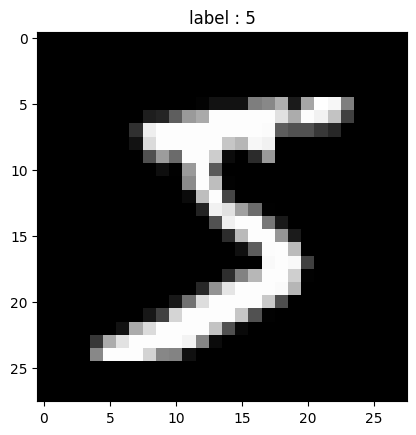

In [11]:
# data 시각화
image, label = train_data[0]

plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.title('label : %s' % label)
plt.show()

## 2) 배치 설정

In [22]:
# train parameters
batch_size = 50
learning_rate = 0.0001
epoch_num = 15

In [23]:
# 미니 배치 구성
# shuffle=True : 학습 각 epoch마다 데이터를 랜덤하게 섞은 후 배치를 나눔 (배치 내부에서 데이터 섞는 것이 아님)
train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                           batch_size = batch_size,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                          batch_size = batch_size,
                                          shuffle = True)

first_batch = train_loader.__iter__().__next__()

## 3) CNN Model 구성

In [25]:
class CNN(nn.Module) :
  def __init__(self) :
    super(CNN, self).__init__()

    # nn.Conv2d(input channel, output channel, kernel size, stride, padding)
    self.conv1 = nn.Conv2d(1, 32, 3, 1, padding='same')
    self.conv2 = nn.Conv2d(32, 64, 3, 1, padding='same')
    self.dropout = nn.Dropout2d(0.25)
    self.fc1 = nn.Linear(3136, 1000)
    self.fc2 = nn.Linear(1000, 10)

  # layer 구성
  def forward(self, x) :
    # input : 1x28x28

    # conv layer 1
    x = self.conv1(x) # 32x28x28
    x = F.relu(x)
    x = F.max_pool2d(x, 2)  # 32x14x14

    # conv layer 2
    x = self.conv2(x) # 64x14x14
    x = F.relu(x)
    x = F.max_pool2d(x, 2)  # 64x7x7

    # dropout
    x = self.dropout(x)

    # fully-connected layer
    x = torch.flatten(x, 1) # 3136, (64x7x7=3136)
    x = self.fc1(x) # 1000,
    x = F.relu(x)
    x = self.fc2(x) # 10,

    output = F.log_softmax(x, dim=1)

    return output

## 4) Train

In [26]:
# 모델 학습 환경 설정 (cuda or cpu)
model = CNN().to(device)

# optimizer & loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [29]:
model.train() # train mode

i = 1
for epoch in range(epoch_num) :   # epoch_num = 15
  for data, target in train_loader :
    # 1. 배치 데이터 준비 (data 50개, target 50개)
    data = data.to(device)
    target = target.to(device)

    # 2. 이전 배치에서 계산된 그래디언트 초기화
    optimizer.zero_grad()

    # 3. 순전파 및 loss 계산
    output = model(data)  # 한 개의 batch에 대한 output(예측값)
    loss = criterion(output, target)  # 예측값과 실제값 간의 loss 계산

    # 4. 역전파
    loss.backward()

    # 5. 가중치 업데이트
    optimizer.step()

    # 1 epoch에 1,200번의 학습 수행 -> 총 15 epoch이므로 총 18,000번의 배치 학습 수행
    if i % 1000 == 0 :
      print('Train Step : {}\tLoss: {:.3f}'.format(i, loss.item()))

    i += 1

Train Step : 1000	Loss: 0.295
Train Step : 2000	Loss: 0.155
Train Step : 3000	Loss: 0.058
Train Step : 4000	Loss: 0.166
Train Step : 5000	Loss: 0.022
Train Step : 6000	Loss: 0.062
Train Step : 7000	Loss: 0.015
Train Step : 8000	Loss: 0.017
Train Step : 9000	Loss: 0.012
Train Step : 10000	Loss: 0.076
Train Step : 11000	Loss: 0.022
Train Step : 12000	Loss: 0.008
Train Step : 13000	Loss: 0.001
Train Step : 14000	Loss: 0.019
Train Step : 15000	Loss: 0.005
Train Step : 16000	Loss: 0.000
Train Step : 17000	Loss: 0.000
Train Step : 18000	Loss: 0.004


## 5) Test

In [32]:
model.eval()  # Test mode

correct = 0

for data, target in test_loader :
  data = data.to(device)
  target = target.to(device)

  output = model(data)

  prediction = output.data.max(1)[1]

  correct += prediction.eq(target.data).sum()

print('Test set Accuracy : {:.2f}'.format(100. * correct / len(test_loader.dataset)))

Test set Accuracy : 99.14
